# Multiple Object Tracking

In this exercise we will run a tracker on top of frame detections from a video. We will use the implementation provided in [this repository](https://github.com/abewley/sort), which is instroduced in [this](https://arxiv.org/abs/1602.00763) technical report. The solution is based on a set of pre-computed bounding box detections using Faster R-CNN. It uses the Hungarian algorithm for box association based on IoU, and uses Kalman filter for tracking.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
%matplotlib inline
from IPython import display as dp

In [2]:
import numpy as np
from skimage import io
import os
import time

Below are all the available sequences in the tracking benchmark. Let's choose one of them:

In [3]:
sequences = ['PETS09-S2L1','TUD-Campus','TUD-Stadtmitte','ETH-Bahnhof',
            'ETH-Sunnyday','ETH-Pedcross2','KITTI-13','KITTI-17',
            'ADL-Rundle-6','ADL-Rundle-8','Venice-2']
s_id = 2
seq = sequences[s_id]

Let's plot the first few frames and show the detections that were previously obtained with Faster R-CNN:

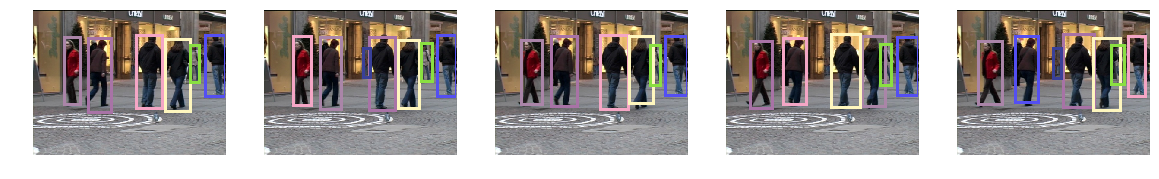

In [ ]:
colours = np.random.rand(32,3) #used only for display
seq_dets = np.loadtxt('data/%s/det.txt'%(seq),delimiter=',') #load faster r-cnn detections for this sequence
phase = 'train'
idxs = range(1,6)
f, axarr = plt.subplots(1, len(idxs),figsize=(20,20))

for i,frame in enumerate(idxs):
    dets = seq_dets[seq_dets[:,0]==frame,2:7] #[x1,y1,w,h]
    fn = 'mot_benchmark/%s/%s/img1/%06d.jpg'%(phase,seq,frame)
    im =io.imread(fn)
    axarr[i].imshow(im)
    axarr[i].axis('off')

    for j in range(np.shape(dets)[0]):
        color = colours[j]
        coords = (dets[j,0],dets[j,1]), dets[j,2], dets[j,3]
        axarr[i].add_patch(plt.Rectangle(*coords,fill=False,edgecolor=color,lw=3))

We can see how almost all objects are roughly detected, but at this point there is no association between detected instances in different frames. Also, Faster R-CNN can sometimes make mistakes. What the tracker will do is to find these matches, and adjust bounding box coordinates based on tracking information.

We will now run the tracker on our detected frame bounding boxes and display the results frame by frame.

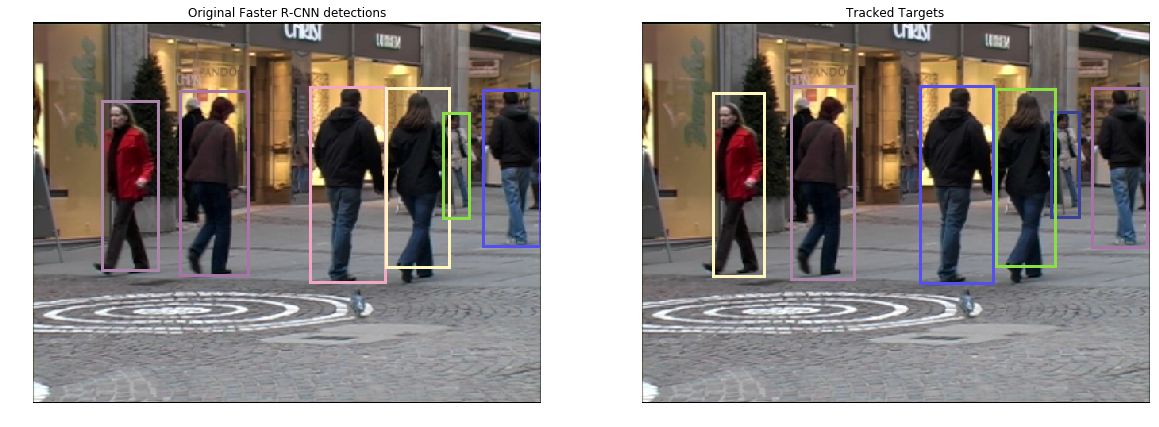

In [ ]:
from sort import Sort

display = True
total_time = 0.0
total_frames = 0
out = []

if display:
    plt.ion() # for iterative display
    fig, ax = plt.subplots(1, 2,figsize=(20,20))

mot_tracker = Sort() #create instance of the SORT tracker

for frame in range(int(seq_dets[:,0].max())): # all frames in the sequence
    frame += 1 #detection and frame numbers begin at 1
    dets = seq_dets[seq_dets[:,0]==frame,2:7]   
    
    if (display):
        fn = 'mot_benchmark/%s/%s/img1/%06d.jpg'%(phase,seq,frame) # read the frame
        im =io.imread(fn)
        ax[0].imshow(im)
        ax[0].axis('off')
        ax[0].set_title('Original Faster R-CNN detections')
        for j in range(np.shape(dets)[0]):
            color = colours[j]
            coords = (dets[j,0],dets[j,1]), dets[j,2], dets[j,3]
            ax[0].add_patch(plt.Rectangle(*coords,fill=False,edgecolor=color,lw=3))
            
    dets[:,2:4] += dets[:,0:2] #convert to [x1,y1,w,h] to [x1,y1,x2,y2] for the tracker input
    total_frames += 1

    if(display):
        ax[1].imshow(im)
        ax[1].axis('off')
        ax[1].set_title('Tracked Targets')

    start_time = time.time()
    trackers = mot_tracker.update(dets)
    cycle_time = time.time() - start_time
    total_time += cycle_time
    
    out.append(trackers)
    for d in trackers:
        if(display):
            d = d.astype(np.uint32)
            ax[1].add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colours[d[4]%32,:]))
            ax[1].set_adjustable('box-forced')

    if(display):
        dp.clear_output(wait=True)
        dp.display(plt.gcf())
        time.sleep(1.0)
        ax[0].cla()
        ax[1].cla()

print("Total Tracking took: %.3f for %d frames or %.1f FPS"%(total_time,total_frames,total_frames/total_time))

Note that the process is very slow because we are plotting the results at each time. If we run the same code with ```display=False``` it will be much faster.

Let's take a look at the output generated for each frame:

In [ ]:
print (out[0])
print (out[1])

The first 4 dimensions give the coordinates of the bounding box, and the fifth one gives the ID of the detected instance. If we print the results for different frames, we will see how some instances disappear, and new ones are created.

**Exercise:** Try to run the tracker on the different sequences provided in the benchmark. 

**Exercise:** If you feel adventurous, you can try to run this code on the video frames from the previous lab, using the detections obtained with SSD.